# Dependencies (if using Binder)

In [1]:
#Important!
#Uncomment and run this cell if using Binder
#!pip install numpy
#!pip install pandas
#!pip install sklearn
#!pip install seaborn
#!pip install matplotlib

# Imports:

In [2]:
#Libraries
import numpy as np #used for arrays and matrices
import pandas as pd #used for DataFrames
import unicodedata #needed for the double-metaphone algorithm
from sklearn.cluster import AffinityPropagation #Our method of clustering
from sklearn.manifold import TSNE #used to visualize our data
import seaborn as sns #required for scatterplot
from sklearn import metrics #provides metrics to measure the performance of our clustering
import matplotlib.pyplot as plt #needed for scatterplots

#We import all of our written functions
from functions import *

# Read the Data:

We create two DataFrames from the same data-set of __[homophones](https://en.wikipedia.org/wiki/Homophone)__.

`edit` will contain the cluster memberships of each word when pairwise distances between words are their __[levenshtein](https://en.wikipedia.org/wiki/Levenshtein_distance)__ (edit) distances.

`phone` will contain the cluster memberships of each word when pairwise distances between words are phonetic.

In [3]:
#Data contained in 'homomphones.csv'
edit = pd.read_csv("homophones.csv")
phone = pd.read_csv("homophones.csv")

In [4]:
#prints the first 12 values of the DataFrame
edit.head(12)

,word,group
0,oar,0
1,or,0
2,ore,0
3,aye,1
4,eye,1
5,I,1
6,bel,2
7,bell,2
8,belle,2
9,bight,3


Two words are in the same `group` if they are homophones of eachother (they sound the same).

In total, there are

In [5]:
len(phone)

116

words in our dataset and 

In [6]:
len(phone["group"].value_counts())

38

different sets of homophones.

For clarity, we will create a column in the `phone` DataFrame to display the double-metaphone code(s) of each word in the dataset:

In [7]:
#dms is a list that will contain each word's double-metaphone code(s)
dms = []
for i in range(len(phone)):
    dms.append(dm(phone.iloc[i]["word"]))

In [8]:
phone["double-metaphone"] = dms

In [9]:
#print the last 12 values of the DataFrame
phone.tail(12)

,word,group,double-metaphone
104,way,34,"(A, F)"
105,weigh,34,"(A, F)"
106,whey,34,"(A, )"
107,we,35,"(A, F)"
108,wee,35,"(A, F)"
109,whee,35,"(A, )"
110,weal,36,"(AL, FL)"
111,we'll,36,"(AL, FL)"
112,wheel,36,"(AL, )"
113,yore,37,"(AR, )"


As we can see from above, sometimes a word is mapped to **2** different phonetic codes. That's why it's called the *double*-metaphone algorithm.

# Affinity Matrices

Next, we will create our affinity matrices. Recall that the affinity matrix is just the negative of a distance matrix.

Our first affinity matrix will be created from a distance matrix where distances in the matrix are defined as the levenshtein (edit) distances between the words in the `edit` DataFrame .

For example, the distance between **"cat"** and **"hat"** would be:

In [10]:
ED("cat","hat",0)

1

Since 1 is the minimum number of single-character edits required to transform **"cat"** into **"hat"** or **"hat"** into **"cat"**. And therefore, their affinity-value would be **-1**.

In [11]:
#af_ma = 'affinity matrix'
af_ma_edit = af_ma = affinity_matrix(edit["word"], "levenshtein",0)

In [12]:
af_ma_edit

array([[ 0, -1, -2, ..., -3, -2, -4],
       [-1,  0, -1, ..., -2, -2, -4],
       [-2, -1,  0, ..., -1, -3, -3],
       ...,
       [-3, -2, -1, ...,  0, -2, -2],
       [-2, -2, -3, ..., -2,  0, -2],
       [-4, -4, -3, ..., -2, -2,  0]])

We can see that there are all 0's down the diagonal. This makes sense since you don't need to perform any single-character edits on a word to transform it into itself.

Next, we create a second affinity matrix that is built from a distance matrix where distances are, instead, defined *phonetically*. 

This time, rather than directly computing the distance between **"cat"** and **"hat"**, themselves, we would instead compute the distance between their phonetic codes.

In [13]:
#The double-metaphone phonetic code for "cat"
dm("cat")

('KT', '')

In [14]:
#The double-metaphone phonetic code for "hat"
dm("hat")

('HT', '')

The distance between these codes is

In [15]:
#DM_LD stands for "double-metaphone levenshtein distance"
DM_LD(dm("cat"),dm("hat"),1)

2

This tells us that the phonetic distance between **"cat"** and **"hat"** is greater than it's edit distance - meaning that **"cat"** and **"hat"** are less similar, phonetically, than they are similar with respect to edit distance. This makes sense since **"cat"** and **"hat"** don't actually sound similar, they just *rhyme*.

If you'd like to better understand how this distance was calculated, please either refer to our paper or to the source code *functions.py*

In [16]:
af_ma_phone = affinity_matrix(phone["word"], "double_metaphone",1)

In [17]:
af_ma_phone

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

It may look like every pair of words has pairwise distance 0, but that's not true - it's just how this big matrix ends up getting displayed. For example:

In [18]:
#phonetic similarity between word 50 and word 21
af_ma_phone[50][21]

-3

is **not** zero.

# Affinity Propagation

Now that we have our affinity matrices, we can go ahead and cluster our words using the **Affinity Propagation** Clustering algorithm.

In [19]:
#Clustering for each affinity matrix
AP_edit = AffinityPropagation(affinity='precomputed')
AP_phone = AffinityPropagation(affinity='precomputed')

In [20]:
#Predict cluster memberhsips for each affinity matrix:
clusters_edit = AP_edit.fit_predict(af_ma_edit)
clusters_phone = AP_phone.fit_predict(af_ma_phone)

In [21]:
#Create a new column in each DataFrame for each cluster membership
edit["cluster"] = clusters_edit
phone["cluster"] = clusters_phone

# Clustering Results

Let's take a quick look at how the words were clustered:

In [22]:
edit.head(12)

,word,group,cluster
0,oar,0,18
1,or,0,6
2,ore,0,0
3,aye,1,3
4,eye,1,3
5,I,1,16
6,bel,2,1
7,bell,2,1
8,belle,2,1
9,bight,3,12


In [23]:
phone.head(12)

,word,group,double-metaphone,cluster
0,oar,0,"(AR, )",15
1,or,0,"(AR, )",15
2,ore,0,"(AR, )",15
3,aye,1,"(A, )",15
4,eye,1,"(A, )",15
5,I,1,"(A, )",16
6,bel,2,"(PL, )",0
7,bell,2,"(PL, )",0
8,belle,2,"(PL, )",0
9,bight,3,"(PT, )",1


For the first 12 values, `phone` certainly does better than `edit`, as `phone`'s `cluster`s correspond with it's `group`s more consistently.

When the distances between words are defined as the Levenshtein distance, we get

In [24]:
len(edit["cluster"].value_counts())

21

`cluster`s. Whereas when the distances are phonetic, we get

In [25]:
len(phone["cluster"].value_counts())

17

`cluster`s.

Note that because there are exactly 38 sets of homophones, neither clustering will have scored perfectly. To score perfectly, a clustering would have to have ended up with **exactly** 38 clusters and the implication that, every set of words that fall in the same `cluster` must also belong to the same `group`.

# Verdict

Let's test the two clusterings to see which one more accurately clustered the words into there proper homophonous `group`s.

We'll use scikit-learn's __[*Completeness*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score)__ score as our metric.
This __[metric](https://en.wikipedia.org/wiki/Completeness_(statistics))__ takes as input each word's group membership as well as cluster membership then returns a score that tells us how well the clustering performed. The score will always be between **0.0** and **1.0** where higher scores are better than lower scores.

In [26]:
metrics.completeness_score(edit["group"],edit["cluster"])

0.8001873829019802

In [27]:
metrics.completeness_score(phone["group"],phone["cluster"])

0.9431511060862334

So in the end, despite the fact that affinity propagation gave us fewer clusters for when we compared words phonetically vs. via edit distance, **the phonetic method ultimately gave us a superior clustering**.

# t-SNE plots

While metrics are a rigorous and fool-proof way to test the performance of an algorithm, it also helps if we can visualize our results to gain a better understanding of how well our clustering performed.

Fortunately, there is an ingenious algorithm that can allow us to visualize our data: __[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)__. All it requires is that we provide it with a distance matrix - information on how far each two points (words) are from eachother. As noted earlier, an affinity matrix is just the negative of a distance matrix, and thus a distance matrix is just the negative of an affinity matrix. 

In [28]:
#Create our distance matrices:
#di_ma stands for "distance matrix"
di_ma_edit = -af_ma_edit
di_ma_phone = -af_ma_phone

t-SNE takes a hyper-parameter known as `perplexity` as it's argument. The visual results of a t-SNE plot depend greatly on the value chosen for `perplexity` as is shown __[here](https://distill.pub/2016/misread-tsne/)__

We'll go with `perplexity=10` this time, but feel free to experiment with other values, too.

In [29]:
perplexity = 10

Each of our plots will be in two dimensions, for simplicity's sake, so we pass argument: `n_components=2`.

In [30]:
#Initialize our t-SNE clusterings
#One for edit distances and one for phonetic distances
TSNE_edit = TSNE(n_components=2, perplexity=perplexity, metric='precomputed')
TSNE_phone = TSNE(n_components=2, perplexity=perplexity, metric='precomputed')

In [31]:
#Pass our distance matrices as arguments to recieve our components
#TCs means "t-SNE components"
TCs_edit = pd.DataFrame(TSNE_edit.fit_transform(di_ma_edit))
TCs_phone = pd.DataFrame(TSNE_phone.fit_transform(di_ma_phone))

In [32]:
#Appropriately title the columns of our components as 'TCX' and 'TCY' as our 'X' and 'Y' axes
TCs_edit.columns = ["TCX","TCY"]
TCs_phone.columns = ["TCX","TCY"]

In [33]:
#Merge our t-SNE components with our older DataFrames:
edit = pd.concat([edit,TCs_edit], axis=1, join='inner')
phone = pd.concat([phone,TCs_phone], axis=1, join='inner')

In [34]:
edit.head(12)

,word,group,cluster,TCX,TCY
0,oar,0,18,53.209229,76.110176
1,or,0,6,46.996250,71.498581
2,ore,0,0,48.309429,60.985668
3,aye,1,3,-36.992531,25.863525
4,eye,1,3,-28.790991,24.447079
5,I,1,16,-42.596378,-5.045608
6,bel,2,1,-9.788130,-35.210903
7,bell,2,1,-6.172278,-41.556351
8,belle,2,1,-7.939948,-48.455708
9,bight,3,12,78.307594,-6.474800


In [35]:
phone.head(12)

,word,group,double-metaphone,cluster,TCX,TCY
0,oar,0,"(AR, )",15,25.208714,12.836110
1,or,0,"(AR, )",15,24.687193,13.033195
2,ore,0,"(AR, )",15,26.139648,13.242627
3,aye,1,"(A, )",15,12.993935,7.789562
4,eye,1,"(A, )",15,12.238345,7.407204
5,I,1,"(A, )",16,12.307961,5.815699
6,bel,2,"(PL, )",0,-3.832036,-17.449820
7,bell,2,"(PL, )",0,-3.829729,-17.452951
8,belle,2,"(PL, )",0,-3.829885,-17.453936
9,bight,3,"(PT, )",1,-5.279347,-15.214774


As we can see from looking at the DataFrames above, t-SNE has given us a pair of (X,Y) coordinates for each of our words so that we may plot each of our words as point on a scatterplot.

We will end up creating four scatterplots in total: 2 plots for the **levenshtein** distance based clustering and 2 for the **phonetic** distance based clustering. Both plots for each method will display the same scatterplot, but will have points coloured with different hues. (Note that each method - **levenshtein** and **phonetic** - will give us a different scatterplot, however.) The first plot for each method will colour the points based on their `group` membership, and the second plot will colour the points based on their `cluster` membership. Visually, a clustering method has performed well if all the sets of points in the first plot that share a colour, *mostly* also share **a** colour in the second plot. (Note that they need not share the *same* colour, but rather *some*  colour.) More concretely, this translates to meaning "a clustering method has performed well if all the sets of points in the first plot that share a *`group` membership*, *mostly* also share a *`cluster` membership* in the second plot". This is similar to how we measured the performance of our clustering with a metric, earlier - but this time, we're doing a *visual* test, rather than a *statistical* test.

In [36]:
#Needed to colour our plots
num_groups = len(edit["group"].value_counts())
num_clusters_edit = len(edit["cluster"].value_counts())
num_clusters_phone = len(phone["cluster"].value_counts())

In [37]:
#The titles of our plots
title1 = "t-SNE plot with perplexity=" + str(perplexity) +"\n(colours tell us group membership)"
title2 = "t-SNE plot with perplexity=" + str(perplexity) +"\n(colours tell us cluster membership)"

In [38]:
#Define the dimensions of our plots
dim_plot = (20,15)

### Edit Distance Based Clustering Visualization:

Text(0.5, 1.0, 't-SNE plot with perplexity=10\n(colours tell us cluster membership)')

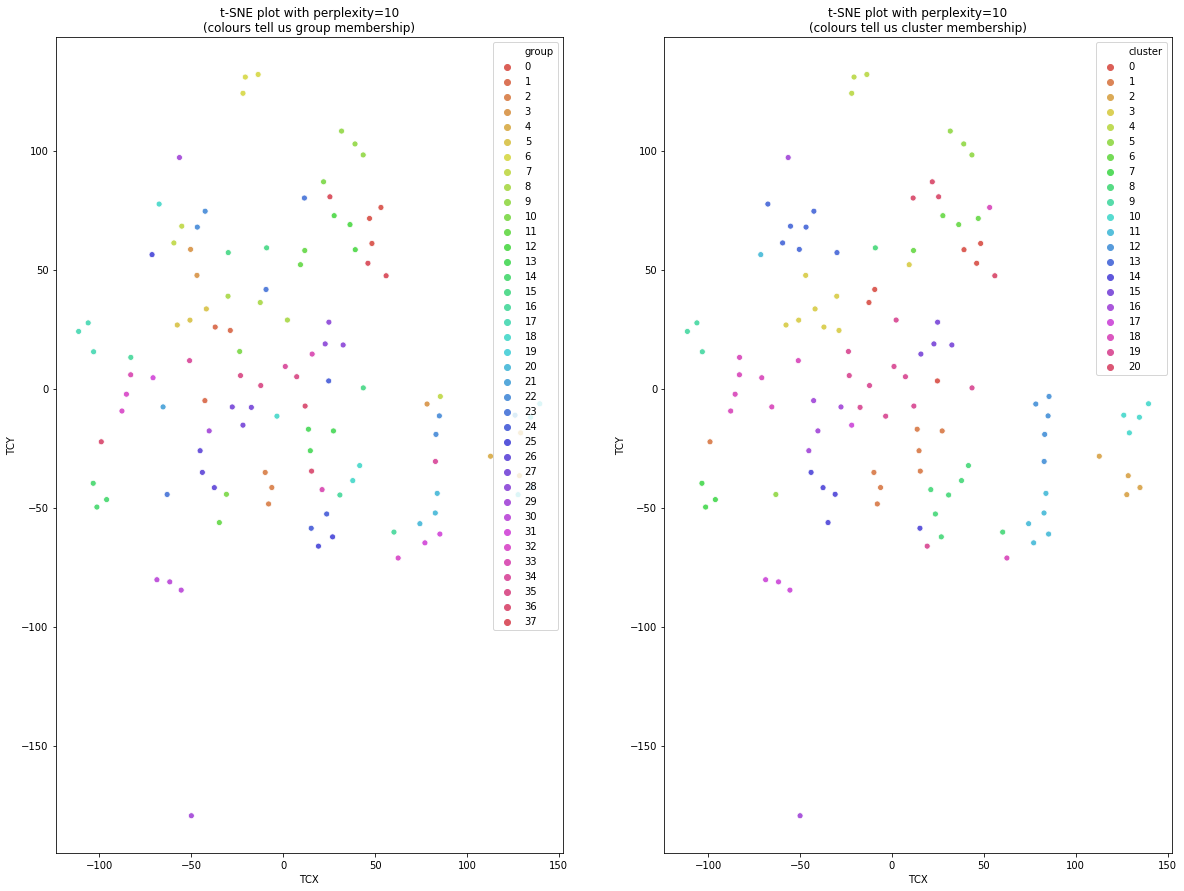

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=dim_plot)
sns.scatterplot(ax = ax[0], x="TCX", y="TCY", hue="group", palette=sns.color_palette("hls", num_groups), data=edit).set_title(title1)
sns.scatterplot(ax = ax[1], x="TCX", y="TCY", hue="cluster", palette=sns.color_palette("hls", num_clusters_edit), data=edit).set_title(title2)

### Phonetic Distance Based Clustering Visualization:

Text(0.5, 1.0, 't-SNE plot with perplexity=10\n(colours tell us cluster membership)')

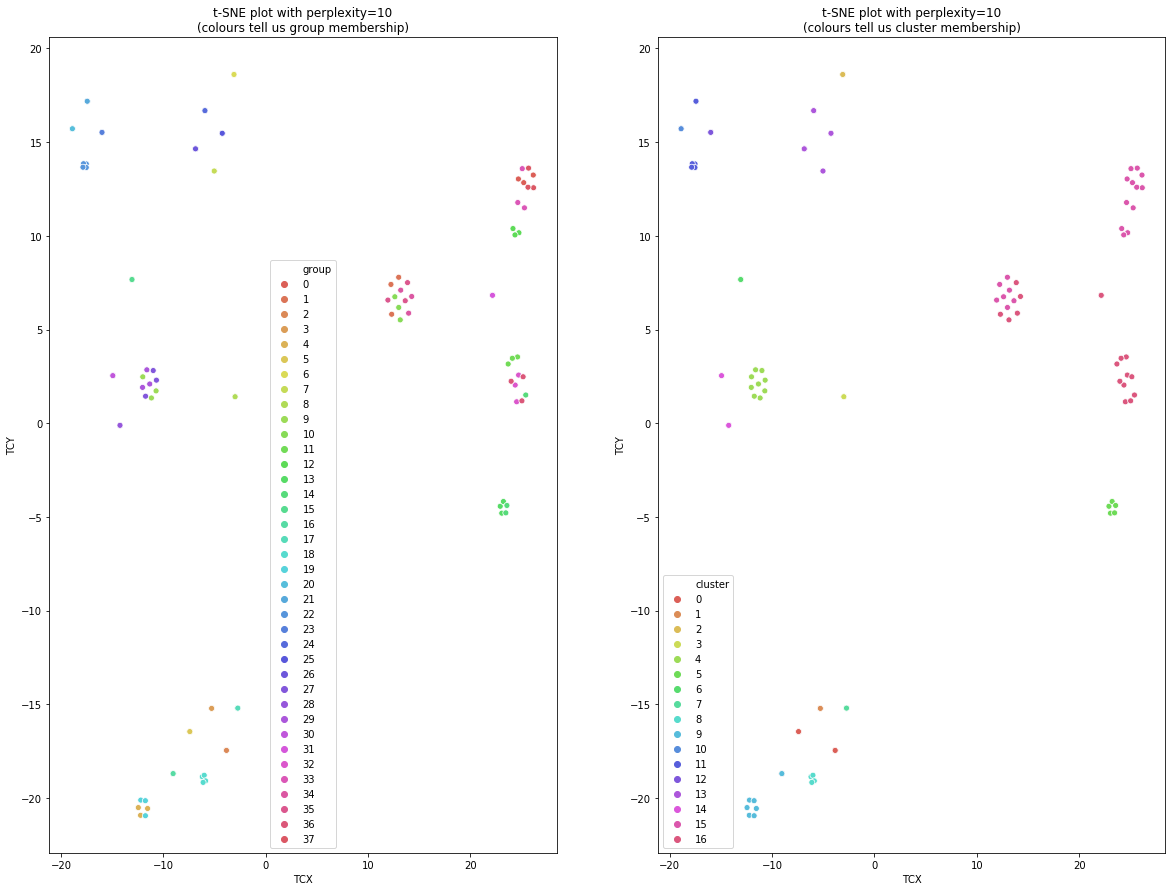

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=dim_plot)
sns.scatterplot(ax = ax[0], x="TCX", y="TCY", hue="group", palette=sns.color_palette("hls", num_groups), data=phone).set_title(title1)
sns.scatterplot(ax = ax[1], x="TCX", y="TCY", hue="cluster", palette=sns.color_palette("hls", num_clusters_phone), data=phone).set_title(title2)

It should be noted that, because t-SNE only takes as input a simple distance matrix that merely specifies distances between points (words), it will not *always* give us the most accurate plots. But with that said, from looking at the t-SNE plots with `perplexity=10`, it appears that the phonetic method did a much better job than the edit-based method when it came to maximizing the distances between different clusters.

And while it's quite difficult to tell, visually, whether *most* points that belong to the same `group` also beolong to the same `cluster`, it's not *that* difficult to determine whether of not *some* points that belong to the same `group` also belong to the same `cluster` - especially for the phonetic plot. And from visually sampling a few sets of points, it appears clear that the phonetic method beats the levenshtein method here, too.

# Closing

And with that, I hope that we've properly demonstrated to you - both **Statistically** and **Visually** - that clustering words based on a phonetic distance is superior to clustering words based on a levenshtein (edit) distance when the goal is to cluster together similar sounding words.

#  ___________
< Thanks for Reading! >
  -------------------------
        \   ^__^
         \  (oo)\_______
            (__)\       )\/\
                ||----w |
                ||     ||